# Introduction

在这场比赛中，我们被要求预测一个商品销售的价格，所以这是一个回归问题

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import string

%matplotlib inline

In [2]:
train = pd.read_table('train.tsv', engine='c')
test = pd.read_table('test.tsv', engine='c')

### 导入数据观看数据的维度,是否有缺失值,特征之间的关联度等等

In [3]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### 查看数据的维度
train_id 是数据id  
name 是商品名  
item_condition_id 是卖方提供的物品状况  
category_name 是商品类别  
brand_name 是品牌  
price 是价格也就是我们要预测的y  
shipping 是是否包邮  
item_description 是买家评价  

In [4]:
print ('训练集大小:{}\n测试集大小:{}'.format(train.shape, test.shape))


训练集大小:(1482535, 8)
测试集大小:(693359, 7)


### 目标分布

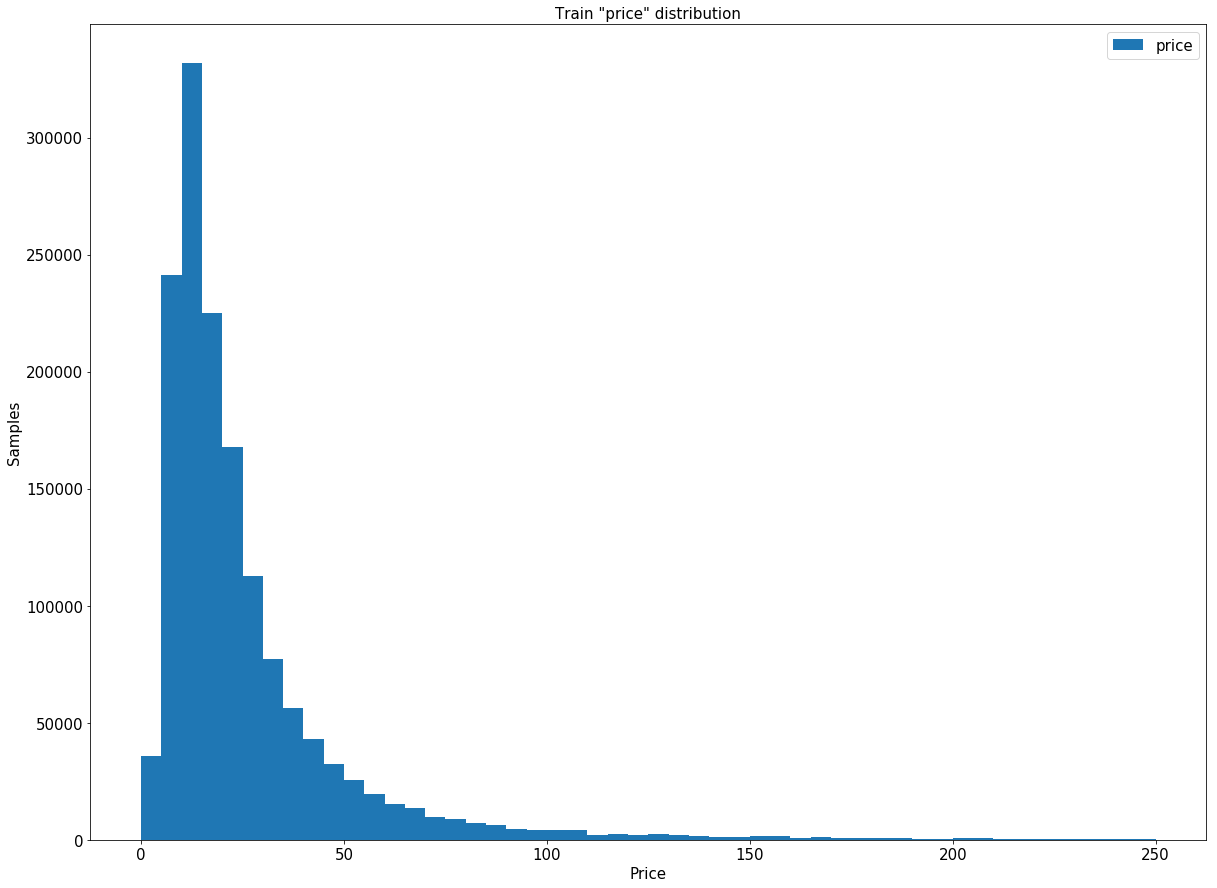

In [5]:
plt.figure(figsize=(20, 15))
plt.hist(train['price'], bins=50, range=[0,250], label='price')
plt.title('Train "price" distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

### 目标信息

In [6]:
train['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

我们看到价格的均值在26.7左右,但是也有像2009那样的最大值,变量分布左偏待会所以让我们对价格进行对数转换

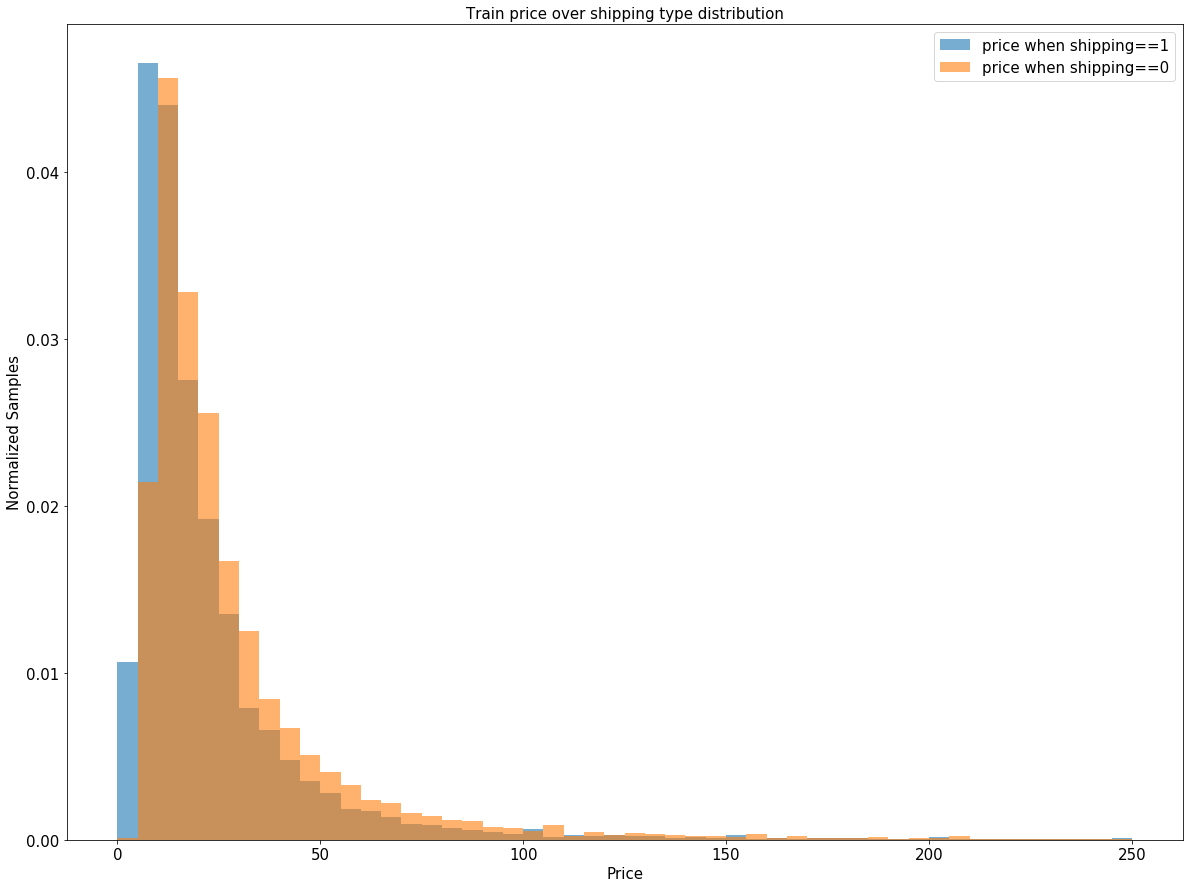

In [7]:
plt.figure(figsize=(20, 15))
bins=50
plt.hist(train[train['shipping']==1]['price'], bins, normed=True, range=[0,250],
         alpha=0.6, label='price when shipping==1')
plt.hist(train[train['shipping']==0]['price'], bins, normed=True, range=[0,250],
         alpha=0.6, label='price when shipping==0')
plt.title('Train price over shipping type distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Normalized Samples', fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

我们发现发货是否包邮,并没有将价格分开.但这并不带表这个特征没有用处

## 填充缺失值

这里用log1p来处理目标y是因为防止出现0和负数

In [8]:
y_train = np.log1p(train['price'])
train['category_name'] = train['category_name'].fillna('Other').astype(str)
train['brand_name'] = train['brand_name'].fillna('missing').astype(str)
train['shipping'] = train['shipping'].astype(str)
train['item_condition_id'] = train['item_condition_id'].astype(str)
train['item_description'] = train['item_description'].fillna('None')

### 文本哑变量化

In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(field):
    field_idx = list(train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])
    
vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=5000,
        preprocessor=build_preprocessor('name'))),
    ('category_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_name'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=5000,
        preprocessor=build_preprocessor('item_description'))),
])
X_train = vectorizer.fit_transform(train.values)
X_train

### 利用ridge算法进行预测

In [ ]:
def get_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

cv = KFold(n_splits=10, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train):
    model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)
    model.fit(X_train[train_ids], y_train[train_ids])
    y_pred_valid = model.predict(X_train[valid_ids])
    rmsle = get_rmsle(y_pred_valid, y_train[valid_ids])
    print(f'valid rmsle: {rmsle:.5f}')
    break

### 算法精确准确率并不高, 我们可以调高 在文本哑变量化中TfidfVectorizer 的max_feature  参数的值

### 单个ridge模型的准确率不行这时我们就可以用lightgbm了.进行多个模型组合具体可以看代码文件